## 1. Time Series Classification Part 1: Feature Creation/Extraction

The dataset contains 7 folders that represent seven types of activities. In
each folder, there are multiple files each of which represents an instant of a human
performing an activity.
1
Each file containis 6 time series collected from activities
of the same person, which are called avg
rss12, var
rss12, avg
rss13, var
rss13,
vg
rss23, and ar
rss23. There are 88 instances in the dataset, each of which con-
tains 6 time series and each time series has 480 consecutive values.

In this problem,
I will classify the activities of humans based on time series obtained by a Wireless
Sensor Network.

### (a) Obtain Data

Import packages

In [1]:
import csv
import os

import pandas as pd
import numpy as np

from sklearn.utils import resample

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegressionCV

import statsmodels.api as sm

from sklearn.metrics import confusion_matrix, roc_curve, auc

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

# refer to https://docs.python.org/3/library/warnings.html
import warnings
warnings.filterwarnings('ignore')

Get the AReM Data Set

In [2]:
COLUMNS = ["time","avg_rss12","var_rss12","avg_rss13","var_rss13","avg_rss23","var_rss23"]
OG_COLUMNS = ["# Columns: time","avg_rss12","var_rss12","avg_rss13","var_rss13","avg_rss23","var_rss23"]
STATS = ['mean', 'std', 'min', '1st_quartile', 'median', '3rd_quartile', 'max']
ORDERED_STATS = ['min', 'max', 'mean', 'median', 'std', '1st_quartile', '3rd_quartile']
PATH = '../data/AReM/'
sniffer = csv.Sniffer()

### (b) Splitting Data

In [3]:
trainset = []
testset = []
for p, dir, files in os.walk(PATH):
    for f in files:
        if 'pdf' not in f:                
            fpof = os.path.join(p, f)
            if ('bending1' in fpof) or ('bending2' in fpof):
                if ('dataset1.csv' in fpof) or ('dataset2.csv' in fpof):
                    testset.append(fpof)
                else:
                    trainset.append(fpof)
            else:
                if ('dataset1.csv' in fpof) or ('dataset2.csv' in fpof) or ('dataset3.csv' in fpof):
                    testset.append(fpof)
                else:
                    trainset.append(fpof)

trainset.pop(0)

'../data/AReM/.DS_Store'

### (c) Feature Extraction

In [4]:
features = []
for i in range(1, 7):
    for s in ORDERED_STATS:
        features.append(f'{s}{i}')  

def prepare_set(files, features, cols, segs=1, standard=False):
    import csv
    instances  = []
    labels = []
    for f in files:
        # get label
        dir = os.path.dirname(f)
        components = dir.split("/")
        labels.append(components[-1])

        # get divider
        fo = open(f)
        divider = sniffer.sniff(fo.read()).delimiter
        
        # read file in different situations
        if divider == ",":
            fc = pd.read_csv(f, skiprows=5, header=None, on_bad_lines='skip')
        elif divider == "\\s+":
            fc = pd.read_csv(f, skiprows=5, sep="\\s+", header=None, on_bad_lines='skip')
        else:
            fc = pd.read_csv(f, skiprows=5, sep="\\s+", header=None, on_bad_lines='skip')
            
        fc.columns = OG_COLUMNS
        
        # distributing time series into equal lengths
        seg_length = int(fc.shape[0] / segs)
        description = []
        for i in range(segs):
            # create segments
            start1 = i * seg_length
            end1 = min((i + 1) * seg_length, fc.shape[0])
            cur_seg = fc[start1 : end1]

            # add segments
            time_col = "# Columns: time"
            cur_describe = cur_seg.describe().drop('count').drop(columns=time_col).T
            description.append(cur_describe.values.flatten())

        instances.append(np.concatenate(description))
            
    # reordering
    fdf = pd.DataFrame(instances)
    curr = []
    for i in range(1, 6*segs+1):
        for s in STATS:
            curr.append(f'{s}{i}')
    fdf.columns = curr
    fdf = fdf.loc[:, features]
    
    # label addition
    fdf['label'] = pd.Series(labels)
    
    return fdf

train_set = prepare_set(trainset, features, OG_COLUMNS)
test_set = prepare_set(testset, features, OG_COLUMNS)


In [5]:
train_res = train_set.describe().loc['std']
display = []
for i in range(1, 7):
    display.append(['std'+str(i), train_res['std'+str(i)]])
pd.DataFrame(display)

,0,1
0,std1,1.758670
1,std2,0.902808
2,std3,0.995959
3,std4,0.473576
4,std5,1.057998
5,std6,0.519420


In [6]:
test_res = test_set.describe().loc['std']
display = []
for i in range(1, 7):
    display.append(['std'+str(i), test_res['std'+str(i)]])
pd.DataFrame(display)

,0,1
0,std1,1.869285
1,std2,0.832472
2,std3,0.760779
3,std4,0.409008
4,std5,0.919274
5,std6,0.525263


In [7]:
res = []
data = train_set.iloc[:, :-1]

# resample data
for sample in range(1000):
    resampled = resample(data)
    temp = resampled.apply(lambda col: np.std(col))
    res.append(temp)
 
res_table = pd.DataFrame(res)
res_table.columns = list(data.columns)

# build a 90% bootsrap confidence interval for the standard deviation of each feature
intervals = res_table.apply(lambda col : (np.percentile(col, 5), np.percentile(col, 95)), axis=0)
intervals.apply(np.around, args=(2,))
intervals = intervals.T
intervals.columns = ['low', 'high']
intervals

,low,high
min1,7.504162,9.978537
max1,3.211246,5.336897
mean1,4.282716,5.381407
median1,4.292903,5.442759
std1,1.537146,1.930368
1st_quartile1,5.118043,6.166779
3rd_quartile1,3.861658,5.489511
min2,0.000000,0.000000
max2,4.630297,5.484772
mean2,1.387887,1.732598


The length of a confidence interval(CI) is a measure of the uncertainty associated with the estimate.
Feature importance in a regression problem refers to the degree to which individual features (independent variables) contribute to explaining the variance in the dependent variable (the target). 
Features with short CI lengths mean less uncertainty associated with the estimate, which means contributing to explaining the variance in the dependent variable. So I chose the three most important time-domain features by choosing the top3 shortest CI. They are: min, std, and 1st quartile.

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

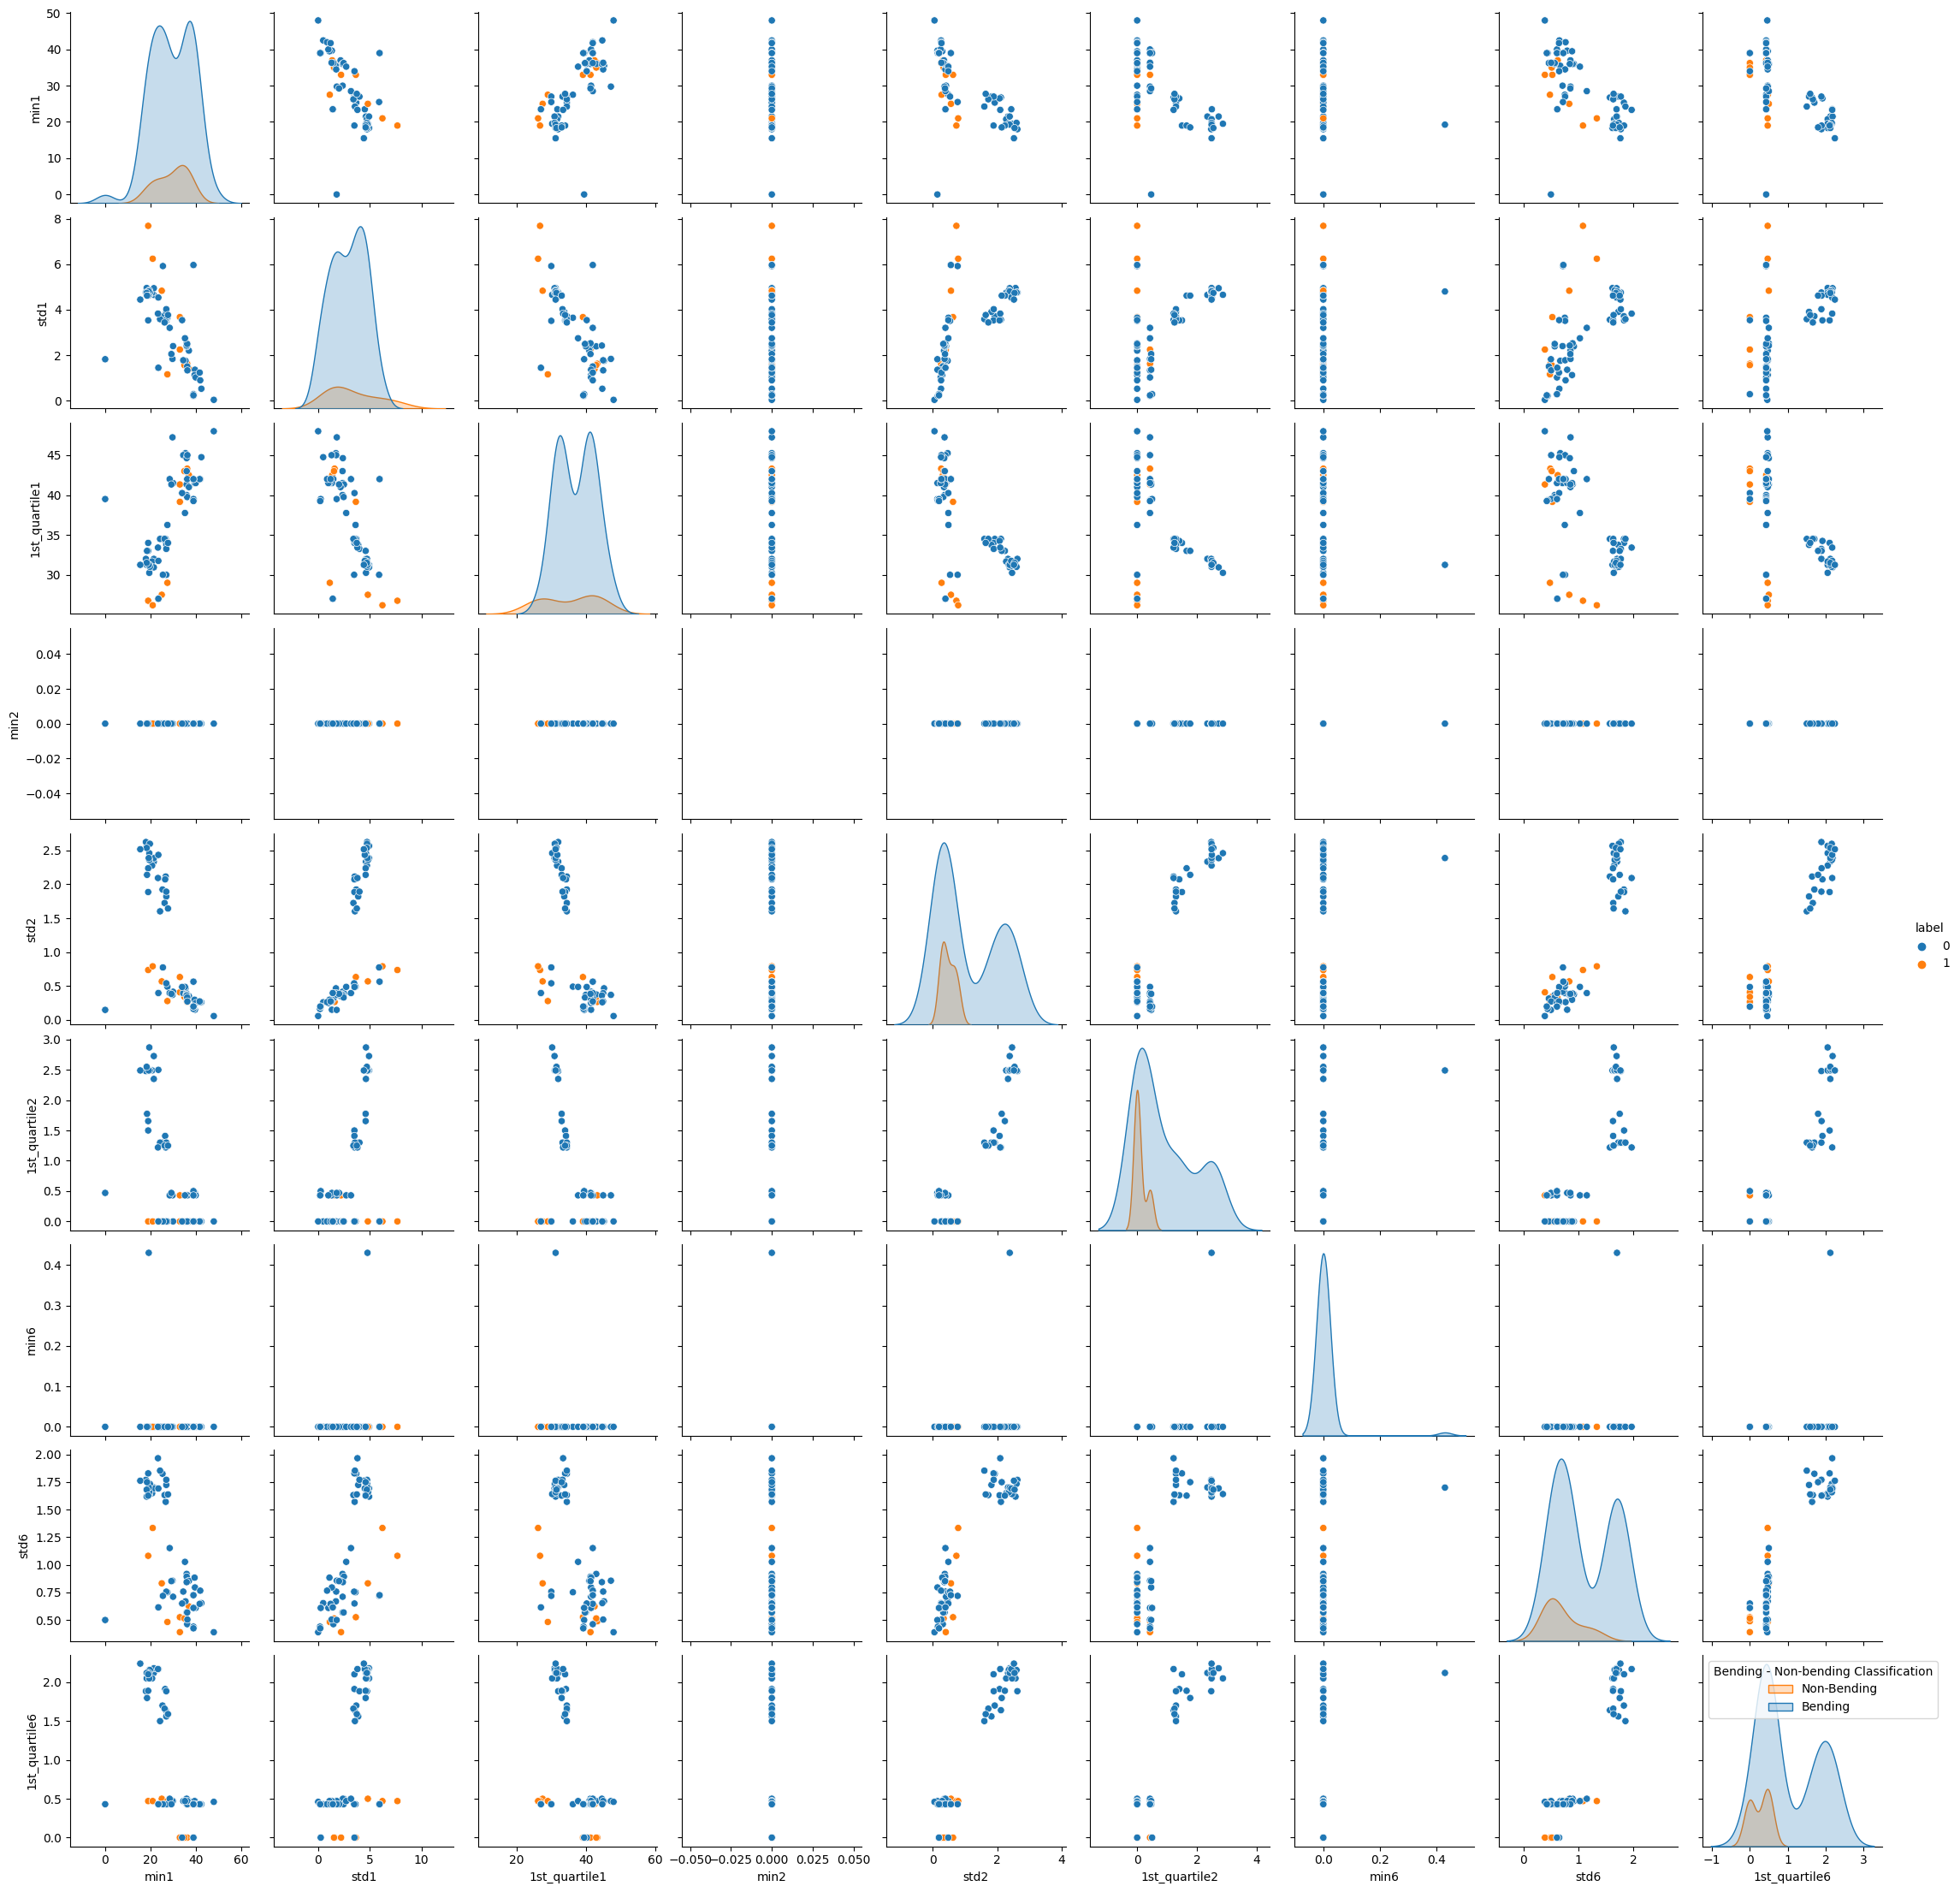

In [8]:
# get columns
columns = []
for i in [1,2,6]:
    for f in ['min', 'std', '1st_quartile']:
        col_name = f + str(i)
        columns.append(col_name)

# get labeled columns
tmp = train_set['label']
train_set.loc[tmp.isin(['bending1', 'bending2']), 'label'] = 1
train_set.loc[tmp != 1, 'label'] = 0
labeled_columns = columns + ['label']
relevant_table = train_set[labeled_columns]

# depict scatter plots
sns.pairplot(relevant_table, hue='label')
plt.legend(title='Bending - Non-bending Classification', loc='upper left', labels=['Non-Bending', 'Bending'])
plt.show()



#### ii. Splitted Plots

In [9]:
# convert text labels into 0/1 labels
def convert_binary(df):
    tmp = df['label']
    df.loc[tmp.isin(['bending1', 'bending2']), 'label'] = 1
    df.loc[tmp != 1, 'label'] = 0
    return df

features = []
for i in range(1, 13):
    for stat in ORDERED_STATS:
        col_name = f'{stat}{i}'
        features.append(col_name)

train_set2 = prepare_set(trainset, features, OG_COLUMNS, segs=2)
test_set2 = prepare_set(testset, features, OG_COLUMNS, segs=2)

train_table2 = convert_binary(pd.DataFrame(train_set2))
train_table2

,min1,max1,mean1,median1,std1,1st_quartile1,3rd_quartile1,min2,max2,mean2,...,1st_quartile11,3rd_quartile11,min12,max12,mean12,median12,std12,1st_quartile12,3rd_quartile12,label
0,36.67,45.00,43.486208,43.71,1.281976,42.3300,44.50,0.0,1.30,0.378667,...,21.000,23.5000,0.0,2.96,0.585750,0.50,0.487918,0.4225,0.8300,1
1,39.00,48.00,44.117042,45.00,1.359836,43.5000,45.00,0.0,1.30,0.250042,...,22.500,23.7500,0.0,4.06,0.543875,0.50,0.473445,0.4300,0.7100,1
2,33.75,47.75,43.278875,45.00,3.473355,42.0000,45.25,0.0,3.00,0.673292,...,28.750,33.7500,0.0,2.18,0.586083,0.47,0.491873,0.0000,0.8700,1
3,33.00,45.75,41.621208,42.33,3.118644,39.6525,44.25,0.0,2.83,0.623083,...,28.310,30.5625,0.0,1.50,0.347500,0.43,0.363144,0.0000,0.5000,1
4,36.50,46.50,44.057167,44.50,1.556971,43.2500,45.00,0.0,1.50,0.381042,...,33.000,36.2500,0.0,1.50,0.388333,0.00,0.478528,0.0000,0.7100,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,20.00,44.25,35.692167,35.50,4.643595,33.0000,39.25,0.0,11.39,3.324208,...,14.000,18.2500,0.0,8.81,2.966917,2.59,1.712062,1.8525,3.7400,0
65,24.25,45.00,36.954208,36.00,3.772836,34.2500,40.25,0.0,8.18,2.392667,...,18.000,21.6700,0.0,9.34,2.838083,2.45,1.890755,1.3825,3.8325,0
66,27.00,42.67,36.337908,36.75,3.655379,33.6700,39.00,0.0,9.71,2.698494,...,16.125,21.0000,0.0,11.15,3.530669,3.08,1.998170,2.1700,4.5150,0
67,26.25,43.40,36.865417,36.25,3.462793,34.3100,40.00,0.0,7.46,2.387250,...,14.330,18.0000,0.0,8.34,2.904458,2.57,1.609793,1.6900,3.7700,0


In [10]:
test_table2 = convert_binary(pd.DataFrame(test_set2))
test_table2

,min1,max1,mean1,median1,std1,1st_quartile1,3rd_quartile1,min2,max2,mean2,...,1st_quartile11,3rd_quartile11,min12,max12,mean12,median12,std12,1st_quartile12,3rd_quartile12,label
0,38.00,42.33,40.946958,41.250,1.102963,40.3100,42.0000,0.00,1.22,0.375667,...,31.3100,36.5000,0.0,1.92,0.552167,0.430,0.510494,0.0000,0.9400,1
1,41.75,44.25,42.643292,42.500,0.641849,42.0000,43.3300,0.00,0.94,0.355000,...,30.0000,33.7500,0.0,3.11,0.533583,0.430,0.575061,0.0000,0.8700,1
2,22.33,42.50,34.334833,35.750,4.772089,30.4750,37.7500,0.00,12.19,3.974958,...,14.7500,18.5000,0.0,8.86,3.400750,3.080,1.804246,2.0600,4.5000,0
3,18.67,45.00,33.762958,34.500,5.001292,30.7500,37.3125,0.43,13.05,4.400833,...,14.7300,18.8125,0.0,8.96,3.378250,3.110,1.803453,2.0575,4.4550,0
4,15.00,45.33,33.591625,34.250,5.121057,30.0000,37.0000,0.00,12.53,4.573042,...,14.1875,18.5000,0.0,8.26,3.206833,2.980,1.710663,1.9800,4.2450,0
5,12.75,51.00,24.675375,24.330,4.856867,22.2500,26.7500,0.00,6.87,0.774500,...,19.4575,21.7500,0.0,4.97,0.936917,0.810,0.818833,0.4700,1.0975,1
6,26.50,31.33,29.071583,29.500,1.133954,28.2500,30.0000,0.00,1.25,0.231208,...,12.3300,20.7625,0.0,6.76,1.473250,1.220,1.238675,0.5000,1.9525,1
7,38.50,48.00,46.127875,46.500,1.151699,45.5000,46.7500,0.00,1.79,0.424542,...,7.0000,12.0000,0.0,3.77,0.870042,0.820,0.678663,0.4600,1.1450,0
8,35.50,45.00,43.043292,43.500,1.874343,42.5000,44.5000,0.00,2.12,0.500667,...,13.6700,17.0000,0.0,4.64,0.874750,0.830,0.635470,0.4700,1.1700,0
9,37.00,46.50,44.447083,45.000,1.667042,44.1875,45.5000,0.00,1.73,0.410458,...,11.7500,18.8125,0.0,5.73,0.906500,0.830,0.741206,0.4300,1.2200,0


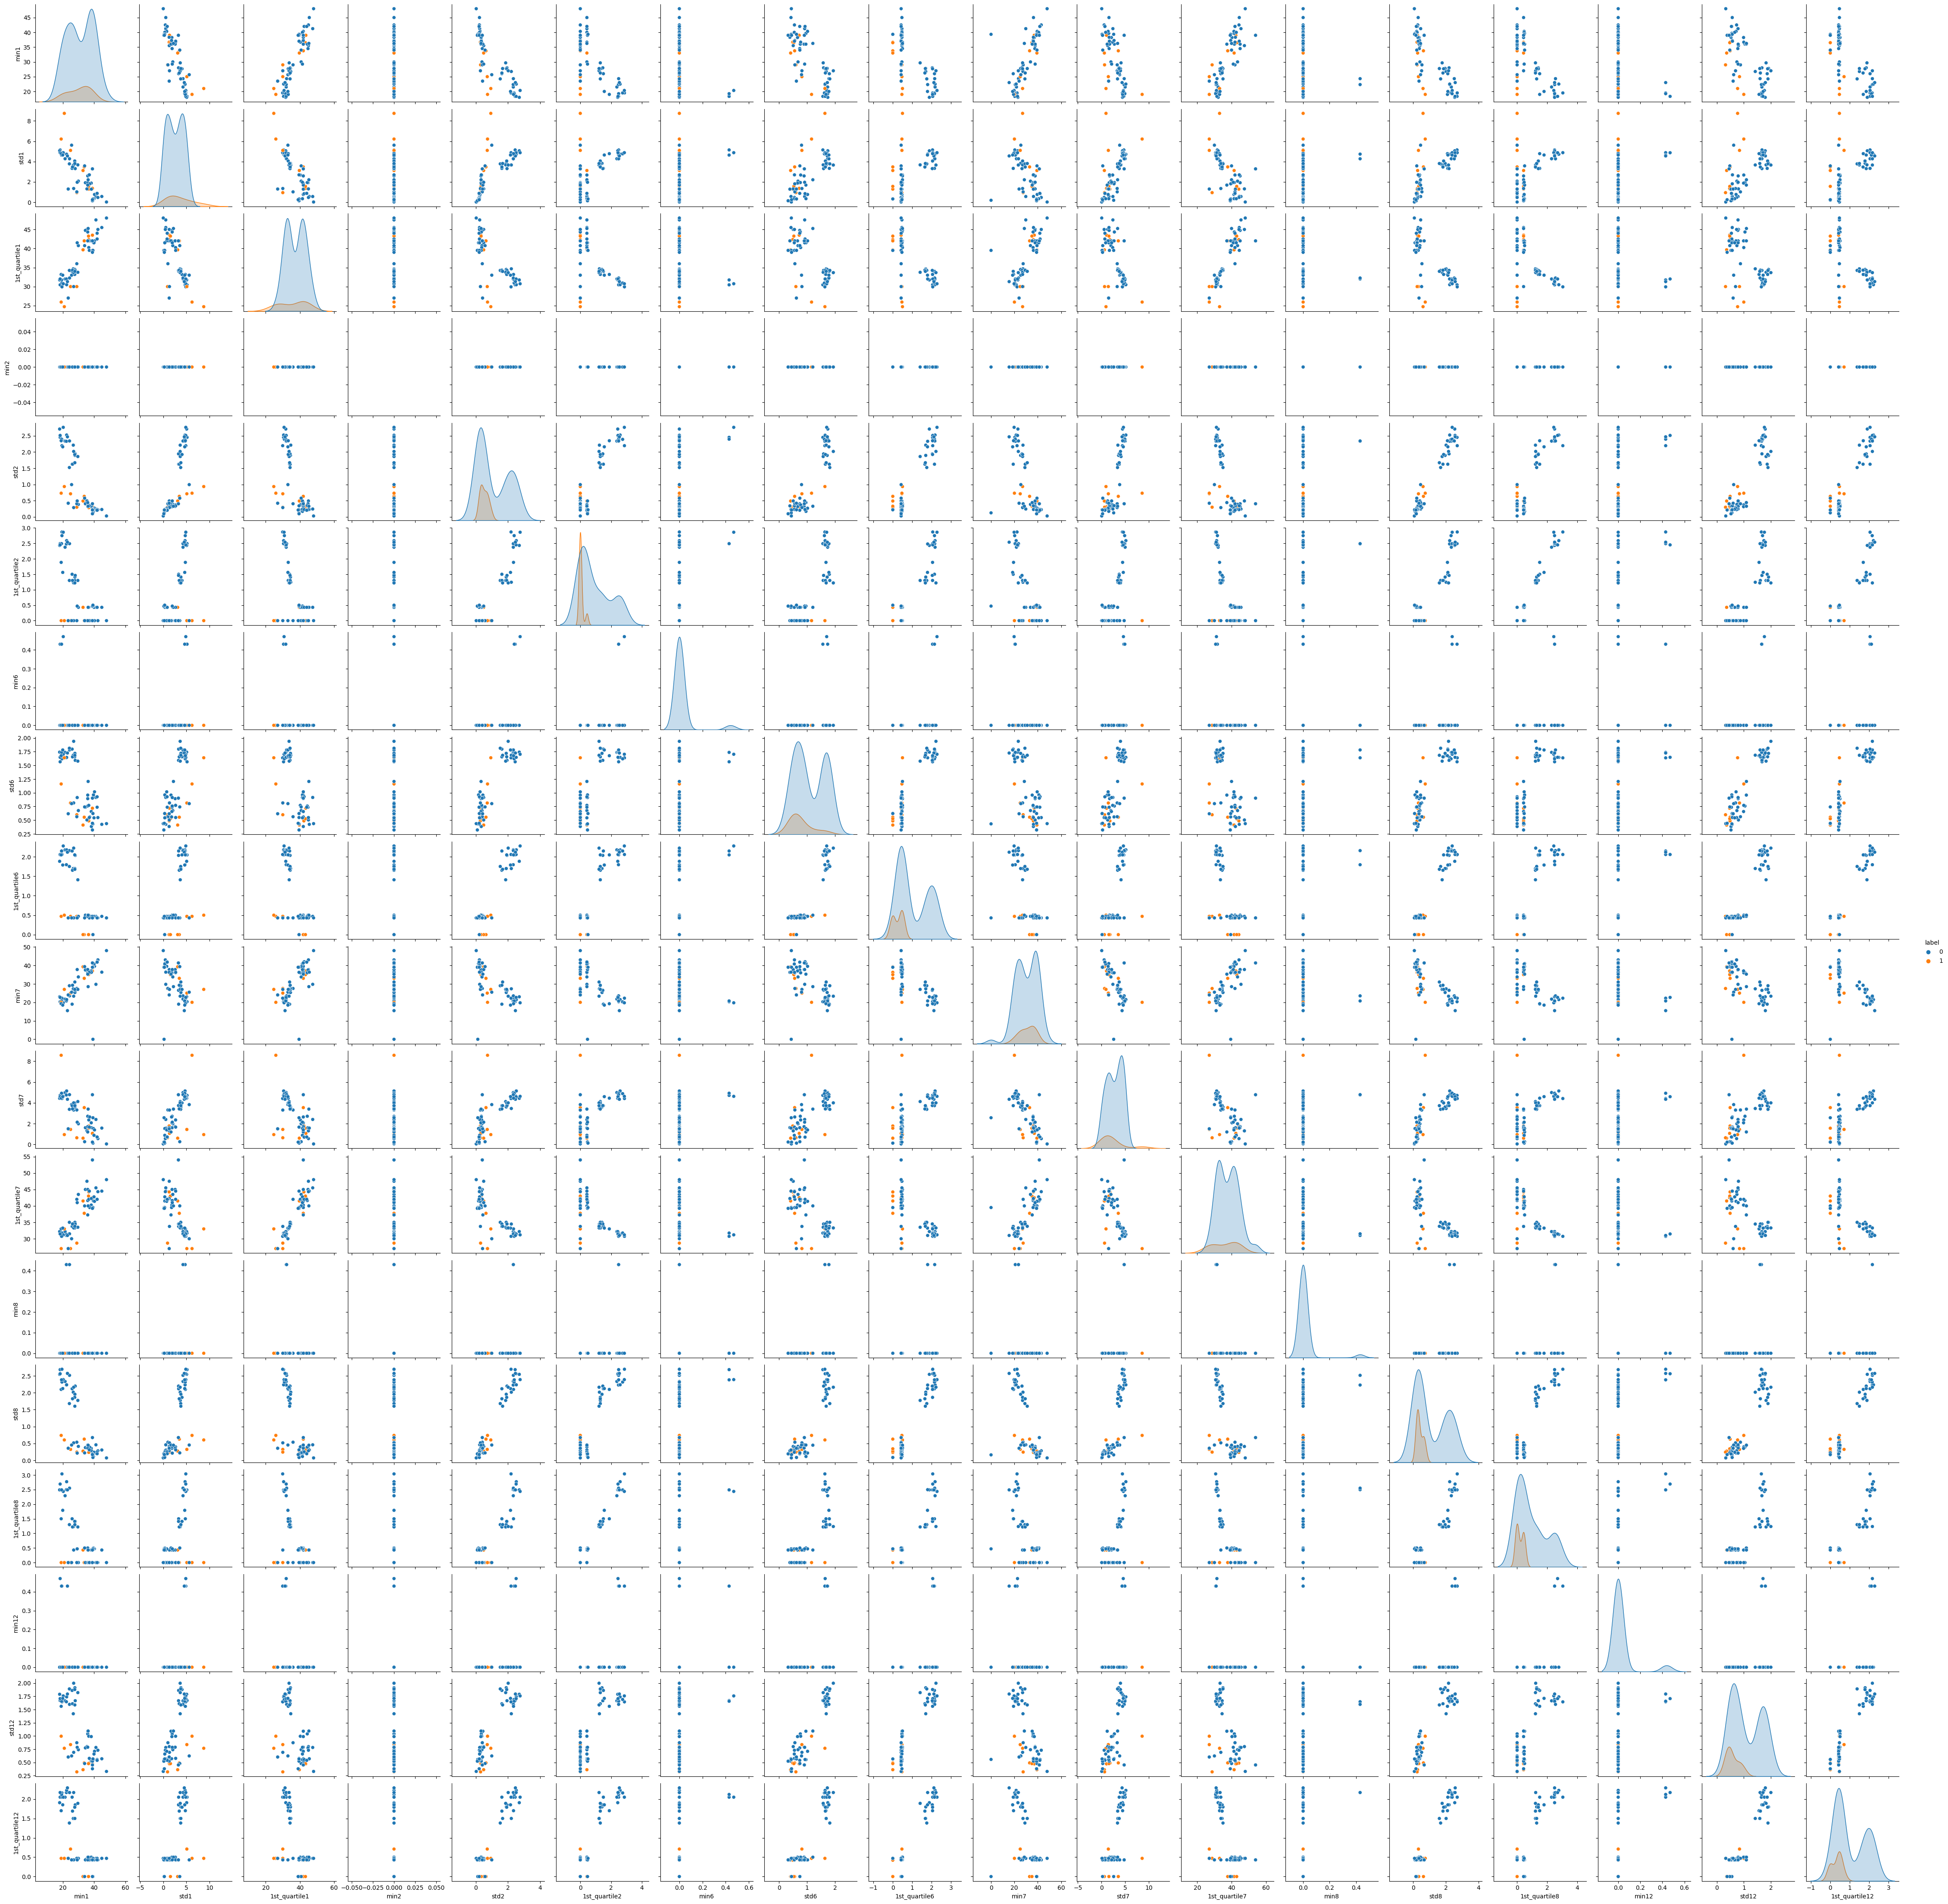

In [11]:
# get columns
columns2 = []
for i in [1, 2, 6, 7, 8, 12]:
    for f in ['min', 'std', '1st_quartile']:
        col_name = f + str(i)
        columns2.append(col_name)

# get labeled columns
tmp = train_set['label']
train_set.loc[tmp.isin(['bending1', 'bending2']), 'label'] = 1
train_set.loc[tmp != 1, 'label'] = 0
labeled_columns2 = columns2 + ['label']
relevant_table2 = train_set2[labeled_columns2]

# depict scatter plots
sns.pairplot(relevant_table2, hue='label')
plt.show()


#### conclusion
Both plots show similar distribution of differently labeled data, so I don't see considerable difference in the results with those of 2(a)i.

#### iii. Time Series Segments

#### Analysis
The right way to perform cross-validation in this problem is to do the Recursive Feature Elimination along with Cross Validation. Because the purpose of cross-validation is to estimate the error on test data and we need much information to achieve that. For this, we dispose our dataset to collect the knowledge of the various predictors. And we do not want to reduce it. So doing the Recursive Feature Elimination along with cross-validation is the right way, whereas doing the RFE before performing cross-validation is the wrong way.

In [12]:
# dispose oversampling situation
def oversample_data_set(data_set):
    
    print('Performing oversampling of dataset...')
    label_0 = data_set.loc[data_set['label'] == "0"].shape[0]
    label_1 = data_set.loc[data_set['label'] == "1"].shape[0]
    minor_count = min(label_0, label_1)
    major_count = max(label_0, label_1)
    
    if label_0 > label_1:
        minor_label = "1"
        major_label = "0"
    else:
        minor_label = "0"
        major_label = "1"
        
    minor_ds = data_set[data_set['label'] == minor_label]
    major_ds = data_set[data_set['label'] == major_label]
    minor_ds = resample(minor_ds, replace=True, random_state=60, n_samples=max(label_0, label_1))
    data_set = pd.concat([major_ds, minor_ds])
    return data_set

# convert text labels to 0/1
def convert_labels(df):
    temp = df['label']
    df.loc[temp.isin(['bending1', 'bending2']), 'label'] = "1"
    df.loc[temp != "1", 'label'] = "0"
    return df

# perform logistic regression
def logistic_regression(train_files, test_files, l_val, numFold, oversample=False, penalty='none'):
    print(f'Running Logistic Regression for l-value {l_val}')

    # get features
    features = []
    for i in range(1, 6 * l_val + 1):
        for s in ORDERED_STATS:
            features.append(f'{s}{i}')

    # get trainset
    train_set = prepare_set(train_files, features, OG_COLUMNS, segs=l_val)
    train_set = convert_labels(pd.DataFrame(train_set))
    
    # dispose oversampling situation
    if oversample:
        train_set = oversample_data_set(train_set)
    
    # get X and Y in trainset
    trainX = train_set.iloc[:, :-1]
    trainY = train_set.iloc[:, -1]
    
    # get the model and selector
    solver = 'liblinear' if penalty == 'l1' else 'lbfgs'
    validator = StratifiedKFold(n_splits=numFold, shuffle=True, random_state=69)
    model = LogisticRegression(penalty=penalty, solver=solver, max_iter=100)
    selector = RFECV(estimator=model, cv=validator, scoring='accuracy')
    selector.fit(trainX, trainY)
    return model, selector


In [13]:
cross_validation_factor = 5
L = 20
combination = {
    'pair(l, p)': [],
    'score': []
}
for l_val in range(1, L + 1):
    model, selector = logistic_regression(trainset, testset, l_val, cross_validation_factor, oversample=False)
    nf = selector.n_features_
    score = np.max(selector.grid_scores_) 
    # score = selector.cv_results_['mean_test_score'].max()
    combination['pair(l, p)'].append((l_val, nf))
    combination['score'].append(round(score, 4))

df = pd.DataFrame(combination)
df

Running Logistic Regression for l-value 1
Running Logistic Regression for l-value 2
Running Logistic Regression for l-value 3
Running Logistic Regression for l-value 4
Running Logistic Regression for l-value 5
Running Logistic Regression for l-value 6
Running Logistic Regression for l-value 7
Running Logistic Regression for l-value 8
Running Logistic Regression for l-value 9
Running Logistic Regression for l-value 10
Running Logistic Regression for l-value 11
Running Logistic Regression for l-value 12
Running Logistic Regression for l-value 13
Running Logistic Regression for l-value 14
Running Logistic Regression for l-value 15
Running Logistic Regression for l-value 16
Running Logistic Regression for l-value 17
Running Logistic Regression for l-value 18
Running Logistic Regression for l-value 19
Running Logistic Regression for l-value 20


,"pair(l, p)",score
0,"(1, 6)",1.0000
1,"(2, 5)",0.9429
2,"(3, 7)",0.9857
3,"(4, 9)",0.9714
4,"(5, 3)",0.9857
5,"(6, 36)",0.9857
6,"(7, 16)",0.9714
7,"(8, 31)",0.9714
8,"(9, 43)",0.9857
9,"(10, 47)",0.9714


#### iv. Confusion Matrix

In [14]:

# perform classification, show the ROC curve and AUC
def classify_and_show(currX, currY, selected_features, isTest=False):
    # predict Y
    if not isTest:
        classifier.fit(currX.loc[:, selected_features], currY.to_numpy(dtype="int"))
    predictY = classifier.predict(currX.loc[:, selected_features])
    
    # get the confusion matrix
    predictY_prob = classifier.predict_proba(currX.loc[:, selected_features])
    y_true = currY.to_numpy(dtype=float)
    y_pre = predictY.round()
    cm = confusion_matrix(y_true, y_pre)
    print(cm)

    # draw the ROC curve and AUC
    fig, axes = plt.subplots(figsize=(6, 4))
    axes.set_title("ROC curves")
    for i, c in enumerate(classifier.classes_):
        y_predicted = predictY_prob[:, i]
        fpr, tpr, thresholds = roc_curve(y_true, y_predicted, pos_label=c)
        curve = auc(fpr, tpr)
        axes.plot(fpr, tpr, label=f"Class: {c}; ROC Curve Area: {round(curve, 4)}")
    axes.plot([0, 1], [0, 1], "--")
    
    
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    plt.show()



Running Logistic Regression for l-value 1
[[60  0]
 [ 0  9]]


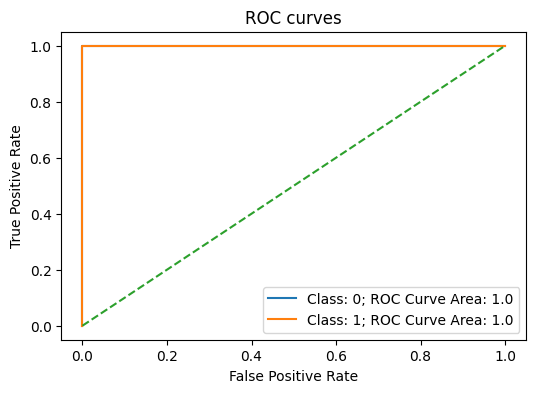

In [16]:
# Report the parameters of the logistic regression βi’s as well as the p-values associated with them.

# get the features
l_value = 1
numFold = 5
features = [f'{s}{i}' for i in range(1, 6 * l_value + 1) for s in ORDERED_STATS]

# Train the logistic regression model and perform feature selection
classifier, selector = logistic_regression(trainset, testset, l_value, numFold)

# Extract selected features
selected_features = [feature for feature, support in zip(features, selector.support_) if support]

# prepare train set and test set
train_set = prepare_set(trainset, selected_features, OG_COLUMNS, segs=1)
train_set = convert_labels(pd.DataFrame(train_set))
trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]
classify_and_show(trainX, trainY, selected_features)

In [17]:
# p-value calculation using statmodel package
df_temp = trainX.loc[:, selected_features]
const_val = sm.add_constant(df_temp.to_numpy(dtype=float))
model = sm.Logit(trainY.to_numpy(dtype=float), const_val)
summary = model.fit(method='bfgs').summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       62
Method:                           MLE   Df Model:                            6
Date:                Tue, 10 Oct 2023   Pseudo R-squ.:                   1.000
Time:                        18:32:25   Log-Likelihood:            -8.8338e-06
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 9.588e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7796   1.51e+07  -5.1

#### v. Test Classifier

[[15  0]
 [ 0  4]]


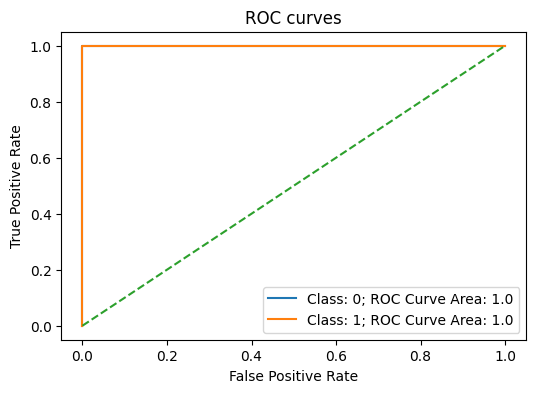

In [18]:
test_set = prepare_set(testset, selected_features, OG_COLUMNS, segs=1)
test_set = convert_labels(pd.DataFrame(test_set))
testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]
classify_and_show(testX, testY, selected_features, isTest=True)

#### vi. Separation

Yes, my classes seem to be well-separated to cause instability in calculating logistic regression parameters. According to the result and report above, the facts that p-value is very small and ROC curve area equals 1 indicates that the classes are well-separated. Yet the measurements of coef, like the std err, indicates that this leads to instability in calculating logistic regression parameters.

#### vii. Imbalance

Yes, I see imbalanced classes. I set non-bending classes as 0 and bending classes as 1. And from the confusion matrices above, 69 instances are of non-bending classes and only 9 instances are of bending classes. So the classes are imbalanced.

In [19]:
# Logistic Regression with oversampling
print("Performing logistic regression with oversampling=True")
cross_validation_factor = 5
L = 20
combination = {
    'pair(l, p)': [],
    'score': []
}
for l_val in range(1, L + 1):
    model, selector = logistic_regression(trainset, testset, l_val, cross_validation_factor, oversample=True)
    nf = selector.n_features_
    score = np.max(selector.grid_scores_) 
    combination['pair(l, p)'].append((l_val, nf))
    combination['score'].append(round(score, 4))

df = pd.DataFrame(combination)
df

Performing logistic regression with oversampling=True
Running Logistic Regression for l-value 1
Performing oversampling of dataset...
Running Logistic Regression for l-value 2
Performing oversampling of dataset...
Running Logistic Regression for l-value 3
Performing oversampling of dataset...
Running Logistic Regression for l-value 4
Performing oversampling of dataset...
Running Logistic Regression for l-value 5
Performing oversampling of dataset...
Running Logistic Regression for l-value 6
Performing oversampling of dataset...
Running Logistic Regression for l-value 7
Performing oversampling of dataset...
Running Logistic Regression for l-value 8
Performing oversampling of dataset...
Running Logistic Regression for l-value 9
Performing oversampling of dataset...
Running Logistic Regression for l-value 10
Performing oversampling of dataset...
Running Logistic Regression for l-value 11
Performing oversampling of dataset...
Running Logistic Regression for l-value 12
Performing oversampli

,"pair(l, p)",score
0,"(1, 4)",1.0000
1,"(2, 7)",0.9833
2,"(3, 3)",1.0000
3,"(4, 3)",0.9917
4,"(5, 3)",0.9917
5,"(6, 3)",0.9917
6,"(7, 2)",0.9917
7,"(8, 3)",0.9917
8,"(9, 9)",1.0000
9,"(10, 6)",1.0000


Running Logistic Regression for l-value 1
Performing oversampling of dataset...
Performing oversampling of dataset...
[[60  0]
 [ 0 60]]


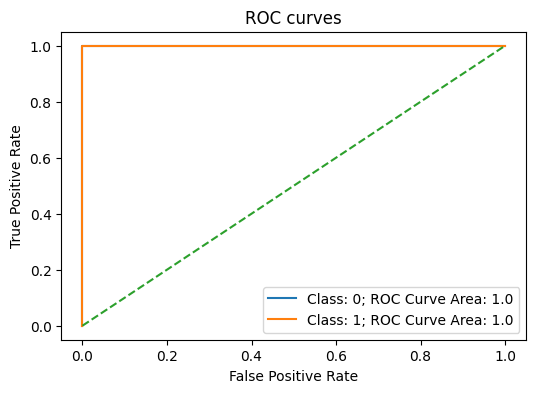

In [20]:
# Running Logistic Regression for l-value 1
# Performing oversampling of dataset
# get selected features
l_value = 1
numFold = 5
features = [f'{s}{i}' for i in range(1, 6 * l_value + 1) for s in ORDERED_STATS]
classifier, selector = logistic_regression(trainset, testset, l_value, numFold, oversample=True)
selected_features = []
for i, feature in enumerate(features):
    if selector.support_[i]:
        selected_features.append(feature)

# show ROC curve and AUC
train_set = prepare_set(trainset, selected_features, OG_COLUMNS, segs=1)
train_set = convert_labels(pd.DataFrame(train_set))
train_set = oversample_data_set(train_set)
trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]
classify_and_show(trainX, trainY, selected_features)

[[15  0]
 [ 0  4]]


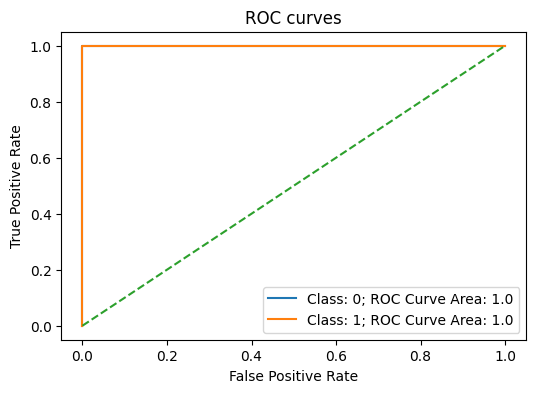

In [21]:
test_set = prepare_set(testset, selected_features, OG_COLUMNS, segs=1)
test_set = convert_labels(pd.DataFrame(test_set))
# test_set = oversample_data_set(test_set)
testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]
classify_and_show(testX, testY, selected_features)

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

In [22]:
# draw the ROC curve and AUC
def show_roc(y_true, predictY_prob, classifier):
    fig, axes = plt.subplots(figsize=(6, 4))
    axes.set_title("ROC curves")
    for i, c in enumerate(classifier.classes_):
        y_predicted = predictY_prob[:, i]
        fpr, tpr, thresholds = roc_curve(y_true, y_predicted, pos_label=c)
        curve = auc(fpr, tpr)
        axes.plot(fpr, tpr, label=f"Class: {c}; ROC Curve Area: {round(curve, 4)}")
    axes.plot([0, 1], [0, 1], "--")
    
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    plt.show()

# global variables
max_acc = 0
opt_L = 1

# utility  method for performing regression based on the given classifier
def classifier_regression(classifier, classifier_name, l_val, kwargs, penalty='none', 
                              is_binary_classification=True, draw_roc=False):
    
    # prepare trainset and testset, convert labels and divide Xs and Ys
    print(f'Running {classifier_name} for l-value {l_val}')
    features = [f'{s}{i}' for i in range(1, 6 * l_val + 1) for s in ORDERED_STATS]
    train_set = prepare_set(trainset, features, OG_COLUMNS, segs=l_val)
    test_set = prepare_set(testset, features, OG_COLUMNS, segs=l_val)
    
    # deal with binary classification
    if is_binary_classification:
        train_set = convert_binary(pd.DataFrame(train_set))
        test_set = convert_binary(pd.DataFrame(test_set))

    # divide train/test Xs and Ys    
    trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]
    testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]
    
    # referred to https://stackoverflow.com/questions/45346550/valueerror-unknown-label-type-unknown
    if is_binary_classification:
        trainY = trainY.astype('int')
        testY = testY.astype('int')
    
    # conduct classification
    classifier2 = classifier(**kwargs)
    classifier2.fit(trainX, trainY)

    # if no ROC, calculate train/test scores and update maximum accuracy and optimal L
    if not draw_roc:    
        train_score = round(classifier2.score(trainX, trainY), 4)
        test_score = round(classifier2.score(testX, testY), 4)
        print(f'Value of L: {l_val} | train_score: {train_score} | test_score: {test_score}')
        print(f'Value of L: {l_val} | train_error: {round((1 - train_score), 4)} | test_error: {round((1 - test_score), 4)}\n')
        global max_acc
        global opt_L
        if test_score > max_acc:
            max_acc = test_score
            opt_L = l_val
        
        if l_val == 20:
            print('\n')
            print(f'The maximum accuracy is {max_acc} (for L-value: {opt_L})')
            print(f'Further calculations will be done with L-value: {opt_L}')
            
    # if ROC, show it    
    else:
        train_predictY_prob = classifier2.predict_proba(trainX)
        test_predictY_prob = classifier2.predict_proba(testX)

        predictY = classifier2.predict(testX)
        cm = confusion_matrix(testY, predictY)
        print(f"Confusion matrix for test data:\n{cm}")
        
        print("ROC of train data")
        show_roc(trainY, train_predictY_prob, classifier2)
        
        print("ROC of test data")
        show_roc(testY, test_predictY_prob, classifier2)



In [23]:
# adopt the varargs concept
args = {
    'penalty' : 'l1', 
    'max_iter' : 100,
    'scoring' : 'accuracy',
    'cv' : 5,
    'random_state' : 69,
    'solver' : 'liblinear'
}

# count the folder
numFold = 5

# conduct regression for each value of L for 20 iterations
for l_val in range(1, 21):
    classifier_regression(LogisticRegressionCV, "Logistic Regression", l_val, args, penalty='none', 
    is_binary_classification=True, draw_roc=False)

Running Logistic Regression for l-value 1
Value of L: 1 | train_score: 1.0 | test_score: 1.0
Value of L: 1 | train_error: 0.0 | test_error: 0.0

Running Logistic Regression for l-value 2
Value of L: 2 | train_score: 0.9565 | test_score: 0.9474
Value of L: 2 | train_error: 0.0435 | test_error: 0.0526

Running Logistic Regression for l-value 3
Value of L: 3 | train_score: 1.0 | test_score: 1.0
Value of L: 3 | train_error: 0.0 | test_error: 0.0

Running Logistic Regression for l-value 4
Value of L: 4 | train_score: 1.0 | test_score: 0.9474
Value of L: 4 | train_error: 0.0 | test_error: 0.0526

Running Logistic Regression for l-value 5
Value of L: 5 | train_score: 1.0 | test_score: 0.9474
Value of L: 5 | train_error: 0.0 | test_error: 0.0526

Running Logistic Regression for l-value 6
Value of L: 6 | train_score: 1.0 | test_score: 0.9474
Value of L: 6 | train_error: 0.0 | test_error: 0.0526

Running Logistic Regression for l-value 7
Value of L: 7 | train_score: 1.0 | test_score: 1.0
Value o

Running Logistic Regression for l-value 1
Confusion matrix for test data:
[[15  0]
 [ 0  4]]
ROC of train data


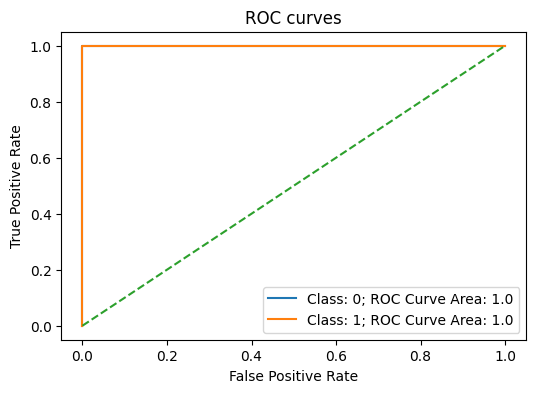

ROC of test data


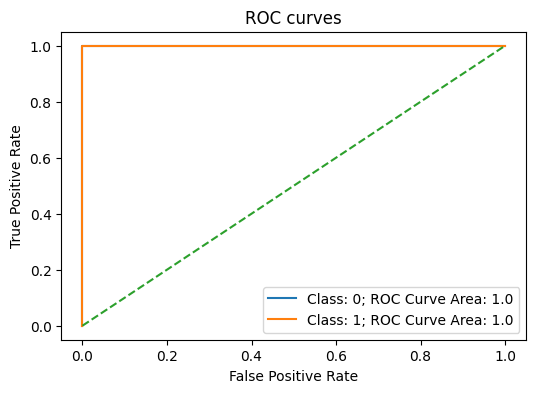

In [24]:
# adopt the varargs concept
args = {
    'penalty' : 'l1', 
    'max_iter' : 100, 
    'solver' : 'liblinear'
}

# best L and fold number
numFold = 5
best_l = 1

# conduct regression with the given classifier using the best value of L calculated from the above cell
classifier_regression(LogisticRegression, "Logistic Regression", best_l, args, penalty='none', 
is_binary_classification=True, draw_roc=True)

#### ii. Comparison

The L1-penalized regression performs better and is also easier to implement. 
According to the testing accuracy, the L1-penalized regression is larger (closer to 1), so it outperforms the variable selection using p-values. 
In L1-penalized regression, feature selection does not need to be done separately (manually), so it's also easier to implement than the variable selection using p-values.

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

In [25]:
# adopt the varargs concept
args = {
    'penalty' : 'l1', 
    'max_iter' : 100,
    'multi_class': 'multinomial',
    'cv': 5,
    'random_state' : 69,
    'solver' : 'saga'
}

# fold count, maximum accuracy, and optimal L
numFold = 5
global max_acc
max_acc = 0
global opt_L
opt_L = 1

# conduct regression for each value of L for 20 iterations
for l_val in range(1, 21):
    classifier_regression(LogisticRegressionCV, "Logistic Regression", l_val, args, penalty='none', 
    is_binary_classification=False, draw_roc=False)

Running Logistic Regression for l-value 1
Value of L: 1 | train_score: 1.0 | test_score: 0.8947
Value of L: 1 | train_error: 0.0 | test_error: 0.1053

Running Logistic Regression for l-value 2
Value of L: 2 | train_score: 1.0 | test_score: 0.9474
Value of L: 2 | train_error: 0.0 | test_error: 0.0526

Running Logistic Regression for l-value 3
Value of L: 3 | train_score: 1.0 | test_score: 0.8421
Value of L: 3 | train_error: 0.0 | test_error: 0.1579

Running Logistic Regression for l-value 4
Value of L: 4 | train_score: 1.0 | test_score: 0.8947
Value of L: 4 | train_error: 0.0 | test_error: 0.1053

Running Logistic Regression for l-value 5
Value of L: 5 | train_score: 1.0 | test_score: 0.8421
Value of L: 5 | train_error: 0.0 | test_error: 0.1579

Running Logistic Regression for l-value 6
Value of L: 6 | train_score: 1.0 | test_score: 0.7895
Value of L: 6 | train_error: 0.0 | test_error: 0.2105

Running Logistic Regression for l-value 7
Value of L: 7 | train_score: 1.0 | test_score: 0.736

Running Logistic Regression for l-value 2
Confusion matrix for test data:
[[2 0 0 0 0 0 0]
 [0 1 1 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]
ROC of train data


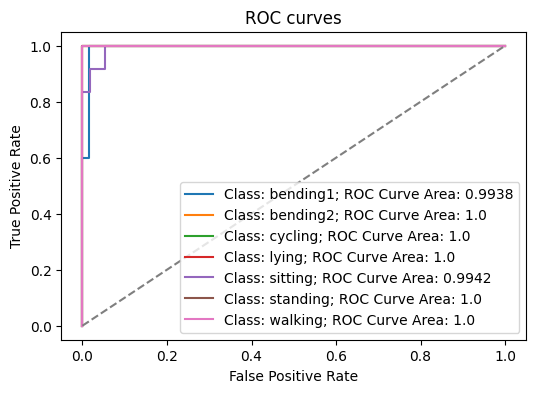

ROC of test data


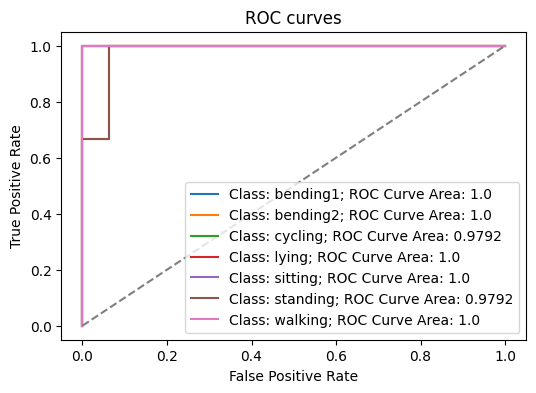

In [26]:
# adopt the varargs concept
args = {
    'penalty' : 'l1', 
    'max_iter' : 100, 
    'multi_class' : 'multinomial',
    'solver' : 'saga'
}

# fold count and the best value of L
numFold = 5
best_l = opt_L

# conduct regression with the given classifier using the best value of L calculated from the above cell
classifier_regression(LogisticRegression, "Logistic Regression", best_l, args, penalty='none', 
is_binary_classification=False, draw_roc=True)

#### ii. Naive Bayes

In [27]:
# adopt the varargs concept
args = {}

# fold count, maximum accuracy, and optimal L
numFold = 5
global max_acc
max_acc = 0
global opt_L
opt_L = 1

# conduct regression for each value of L for 20 iterations
for l_val in range(1, 21):
    classifier_regression(GaussianNB, "Naive Bayes Classifier with Gaussian Prior", l_val, args, penalty='none', 
    is_binary_classification=False, draw_roc=False)

Running Naive Bayes Classifier with Gaussian Prior for l-value 1
Value of L: 1 | train_score: 1.0 | test_score: 0.8947
Value of L: 1 | train_error: 0.0 | test_error: 0.1053

Running Naive Bayes Classifier with Gaussian Prior for l-value 2
Value of L: 2 | train_score: 1.0 | test_score: 0.6316
Value of L: 2 | train_error: 0.0 | test_error: 0.3684

Running Naive Bayes Classifier with Gaussian Prior for l-value 3
Value of L: 3 | train_score: 0.9855 | test_score: 0.7368
Value of L: 3 | train_error: 0.0145 | test_error: 0.2632

Running Naive Bayes Classifier with Gaussian Prior for l-value 4
Value of L: 4 | train_score: 1.0 | test_score: 0.7895
Value of L: 4 | train_error: 0.0 | test_error: 0.2105

Running Naive Bayes Classifier with Gaussian Prior for l-value 5
Value of L: 5 | train_score: 0.9855 | test_score: 0.7895
Value of L: 5 | train_error: 0.0145 | test_error: 0.2105

Running Naive Bayes Classifier with Gaussian Prior for l-value 6
Value of L: 6 | train_score: 0.971 | test_score: 0.63

Running Naive Bayes Classifier with Gaussian Prior for l-value 1
Confusion matrix for test data:
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 2 1 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]
ROC of train data


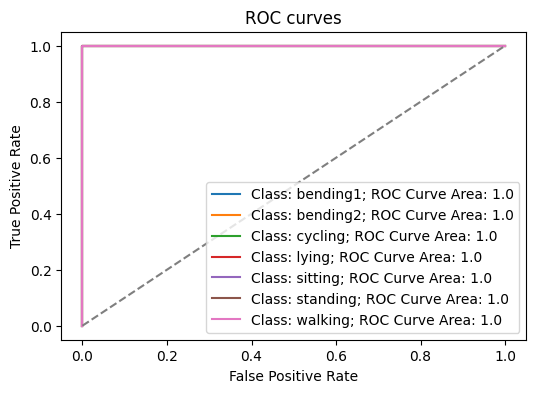

ROC of test data


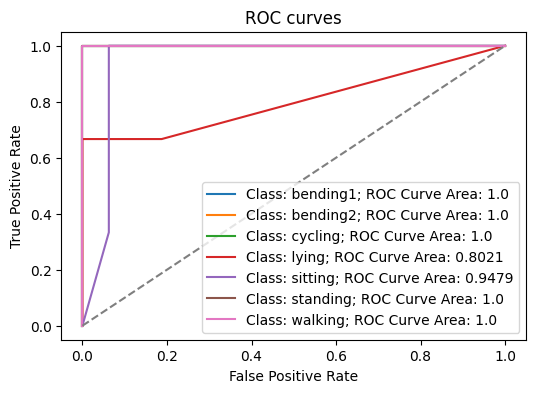

In [28]:
args = {}

# fold count and the best value of L
numFold = 5
best_l = opt_L

# conduct regression with the given classifier using the best value of L calculated from the above cell
classifier_regression(GaussianNB, "Naive Bayes Classifier with Gaussian Prior", best_l, args, penalty='none', 
is_binary_classification=False, draw_roc=True)

In [29]:
# making use of the varargs concept
args = {}

# fold count, maximum accuracy, and optimal L
numFold = 5
global max_acc
max_acc = 0
global opt_L
opt_L = 1

# conduct regression for each value of L for 20 iterations
for l_val in range(1, 21):
    classifier_regression(MultinomialNB, "Naive Bayes Classifier with Multinomial Prior", l_val, args, penalty='none', 
    is_binary_classification=False, draw_roc=False)

Running Naive Bayes Classifier with Multinomial Prior for l-value 1
Value of L: 1 | train_score: 0.9275 | test_score: 0.8947
Value of L: 1 | train_error: 0.0725 | test_error: 0.1053

Running Naive Bayes Classifier with Multinomial Prior for l-value 2
Value of L: 2 | train_score: 0.8841 | test_score: 0.7368
Value of L: 2 | train_error: 0.1159 | test_error: 0.2632

Running Naive Bayes Classifier with Multinomial Prior for l-value 3
Value of L: 3 | train_score: 0.8986 | test_score: 0.7895
Value of L: 3 | train_error: 0.1014 | test_error: 0.2105

Running Naive Bayes Classifier with Multinomial Prior for l-value 4
Value of L: 4 | train_score: 0.913 | test_score: 0.7895
Value of L: 4 | train_error: 0.087 | test_error: 0.2105

Running Naive Bayes Classifier with Multinomial Prior for l-value 5
Value of L: 5 | train_score: 0.9275 | test_score: 0.7368
Value of L: 5 | train_error: 0.0725 | test_error: 0.2632

Running Naive Bayes Classifier with Multinomial Prior for l-value 6
Value of L: 6 | tra

Running Naive Bayes Classifier with Multinomial Prior for l-value 1
Confusion matrix for test data:
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 1 0 2 0]
 [0 0 0 0 0 0 3]]
ROC of train data


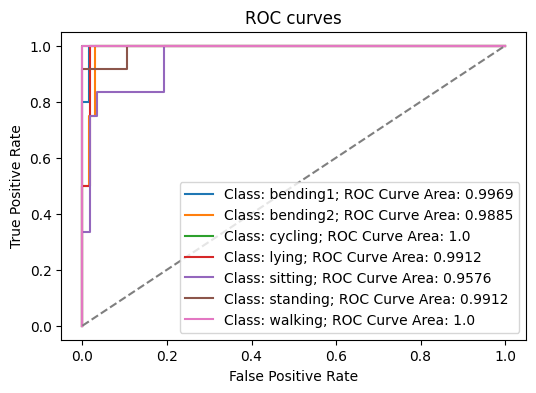

ROC of test data


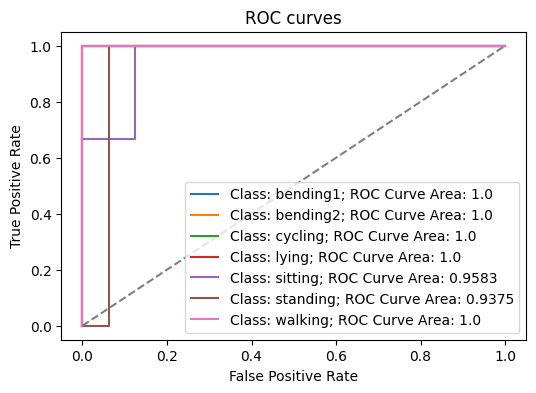

In [30]:
args = {}

# fold count and the best value of L
numFold = 5
best_l = opt_L

# conduct regression with the given classifier using the best value of L calculated from the above cell
classifier_regression(MultinomialNB, "Naive Bayes Classifier with Multinomial Prior", best_l, args, penalty='none', 
is_binary_classification=False, draw_roc=True)

#### ii. Comparison

Logistic Regression is better for multi-class classification in this problem.
According to the ROC, the AUC for the curve of Logistic Regression is the larger than the ones of Gaussian or Multinomial classifer prior, so Logistic Regression performs better in this problem.

#### References:
https://stackoverflow.com/questions/45346550/valueerror-unknown-label-type-unknown
https://docs.python.org/3/library/warnings.html